In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../jigsaw/dataset_text_target.csv")
df_true = df[df.target > 0.5]
df_false = df[df.target <= 0.5]

In [4]:
df_true

,comment_text,target
4,haha you guys are a bunch of losers.,0.893617
5,ur a sh*tty comment.,0.666667
13,It's ridiculous that these guys are being call...,0.600000
31,Yet call out all Muslims for the acts of a few...,0.912500
34,This bitch is nuts. Who would read a book by a...,0.830769
...,...,...
1804786,A sexual predator lives in the White House now...,0.600000
1804825,Who is the jerk in the last row between the C ...,0.833333
1804838,Nobody really cares that she supports the scie...,0.700000
1804857,"I take your point, but I think you're shooting...",0.700000


In [5]:
DATASET_SIZE = 10_000

In [6]:
df = pd.concat([df_true[DATASET_SIZE//2:DATASET_SIZE], df_false[DATASET_SIZE//2:DATASET_SIZE]], axis=0)

<Axes: >

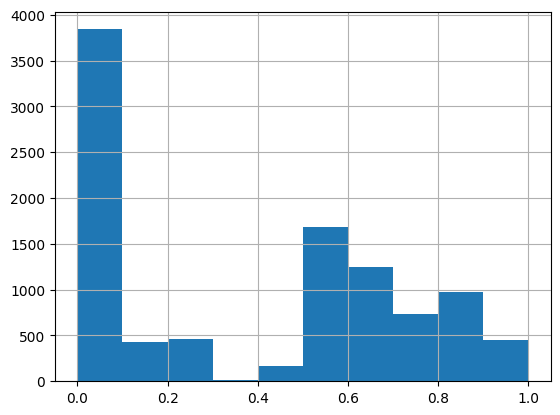

In [7]:
df.target.hist()

In [8]:
mapper = lambda x: 1 if x > 0.5 else 0
df.target = df.target.apply(mapper)

In [9]:
from transformers import BertTokenizer, TFBertForSequenceClassification

/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Trac

In [10]:
x_test = df.comment_text
y_test = df.target

In [11]:
x_test

97577    Of all the devices you mention, only guns are ...
97582    To assume the Clinton and Sanders' campaigns s...
97608    with 5 months to go anything can / will happen...
97635    Blizzards probably weren't added until the '80...
97646    As always, can't wait to stick your horny raci...
                               ...                        
10447    You have a very good and valid point. I would ...
10448    Frankly I look forward to growing oranges in O...
10449    could some one please translate this into comp...
10450    Before we start blazing away, how about trying...
10451    Orcas die earlier in captivity compared to the...
Name: comment_text, Length: 10000, dtype: object

In [12]:
y_test.value_counts()

target
1    5000
0    5000
Name: count, dtype: int64

In [13]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [96]:
max_len = 128

In [97]:
X_test_encoded = tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_len,
    add_special_tokens=True,
    return_tensors='tf'
)

In [15]:
model = TFBertForSequenceClassification.from_pretrained('../bert_model_trained', num_labels=2)

2025-07-27 12:04:19.253673: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-27 12:04:19.253955: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-27 12:04:19.253978: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753598059.254545  381825 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753598059.254606  381825 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the lay

In [98]:
y_test.value_counts()

target
1    5000
0    5000
Name: count, dtype: int64

In [99]:
from sklearn.metrics import classification_report

In [100]:
import tensorflow as tf
y_pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
y_pred = tf.argmax(y_pred.logits, axis=1).numpy()


313/313 [==============================] - 534s 2s/step


In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5000
           1       0.99      0.93      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [104]:
sentences = x_test.tolist()
predicted = y_pred.tolist()
truth = y_test.tolist()
size = len(sentences)

mismatches = []
for i in range(size):
    if predicted[i] == truth[i]:
        continue
    mismatches.append((sentences[i], predicted[i], truth[i]))

In [105]:
mismatches[0]

('Yeah, they could have beat in all their heads with rocks!', 0, 1)

In [106]:
import pandas as pd
errors = pd.DataFrame(mismatches, columns=['sentence', 'predicted', 'truth'])

In [108]:
errors.to_csv("bert_errors.csv", index=False)